[0] ... parent = -1
[1, 10, 3, 6] ... parent = 0
[2] ... parent = 0
[4, 5, 7, 8, 9, 11, 12, 13] ... parent = 2


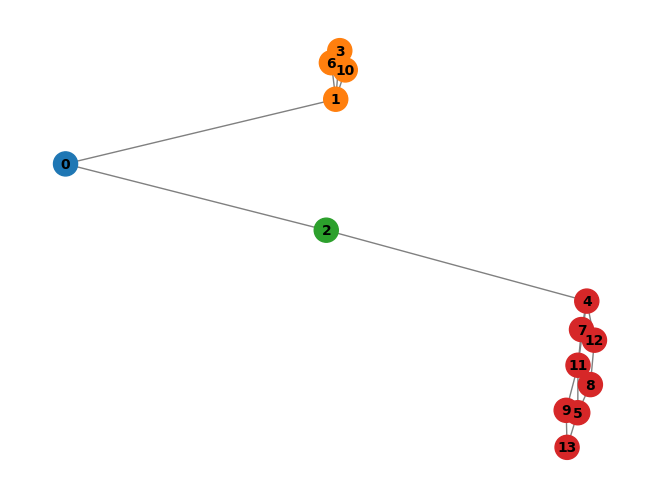

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# --------------------------------------------------------
# --------------------------------------------------------

# ONLY USED FOR VISUALISATION
def calculate_node_distance(P_list, G_list, node_idx, node_d=0):
    if (P_list[node_idx]==-1):
        return node_d
    else:
        node_jdx = find_graph_index(G_list, P_list[node_idx])
        return calculate_node_distance(P_list, G_list, node_jdx, node_d+1)
# ONLY USED FOR VISUALISATION
def calculate_hierarchy_positions(P_list, G_list):
    hierarchy_positions = [0] * len(P_list)
    # Iterate through each value in P_list
    for idx, parent_idx in enumerate(P_list):
        hierarchy_positions[idx]+=calculate_node_distance(P_list, G_list, idx)
    return hierarchy_positions


class tree_graphs:
    def __init__(self, tree_G, tree_P):
        self.graphs = tree_G
        self.parents = tree_P

    # ONLY USED FOR VISUALISATION
    def plot_tree(self):
        hierarchy_positions = calculate_hierarchy_positions(self.parents, self.graphs)

        # Combine the graphs
        plot_combined_graph = nx.compose_all(self.graphs)

        # Add edges based on the parent-child relationships
        for child_index, parent_index in enumerate(self.parents):
            if parent_index != -1:
                # Select arbitrary nodes from the child and parent graphs
                child_node = list(self.graphs[child_index].nodes())[0]
                #parent_node = list(self.graphs[parent_index].nodes())[0]
                parent_node = 0 + parent_index
                # Add an edge between the selected nodes
                plot_combined_graph.add_edge(child_node, parent_node)

        # Create colours for nodes
        node_colors = []
        for plot_i, graph in enumerate(self.graphs):
            node_colors.extend([f'C{plot_i}'] * len(graph.nodes()))

        # Visualize the combined graph
        plot_pos = nx.spring_layout(plot_combined_graph)
        for plot_node, (plot_x, plot_y) in plot_pos.items():
            graph_index = None
            # Find the index of the graph to which this node belongs
            for plot_i, graph in enumerate(self.graphs):
                if plot_node in graph.nodes():
                    graph_index = plot_i
                    break
            if graph_index is not None:
                hierarchy_position = hierarchy_positions[graph_index]
                plot_pos[plot_node] = (plot_x + hierarchy_position * 3, plot_y)

        nx.draw(plot_combined_graph, plot_pos, with_labels=True,
                node_size=300, node_color=node_colors,
                font_size=10, font_weight="bold", edge_color="gray", arrows=True)
        plt.show()



# Check if the graph is complete (fully connected)
def is_complete(graph):
    num_nodes = len(graph.nodes)
    max_edges = num_nodes * (num_nodes - 1) // 2
    return len(graph.edges) == max_edges


# Check if the graph is connected:
# ... If yes, return a list including the original graph
# ... If no, return the list of the component graphs
def check_connect(graph):
    if is_complete(graph):
        return [graph]
    else:
        connected_components = list(nx.connected_components(graph))
        subgraphs = []
        for component in connected_components:
            subgraph = graph.subgraph(component)
            subgraphs.append(subgraph)
        return subgraphs


# Determine the root node of a graph, returns the node index
# and the number of nodes with the max number of edges
# ... In most cases count_max_degree will be 1
# ... If not, we either have a complete or a problematic graph
def find_root(find_G):
    find_degree = dict(find_G.degree)
    find_node = max(find_degree, key=find_degree.get)
    max_degree = max(find_degree.values())
    count_max_degree = sum(1 for degree in find_degree.values() if degree == max_degree)
    return find_node, count_max_degree


# Returns the index of a graph that includes node N
def find_graph_index(find_G, find_N):
    for find_i, find_g in enumerate(find_G):
        if find_N in find_g.nodes:
            return find_i
    return -1  # This should not happen


# Reduces the input graph to a tree of graphs
def reduce_graph_to_tree(reduce_G_input, reduce_print=False):
    red_Tree = check_connect(reduce_G_input)
    red_Parents = [-1]*len(red_Tree)
    red_IDX = 0
    while (red_IDX<len(red_Tree)):
        # Check if graph is fully connected, if yes we are done
        if (is_complete(red_Tree[red_IDX])):
            red_IDX+=1
        # If not, we try to cut it down
        else:
            # Make a test-cut
            red_Gtest = nx.Graph(red_Tree[red_IDX])
            red_Groot, red_Gnum = find_root(red_Gtest)
            edges_to_remove = list(red_Gtest.edges(red_Groot))
            red_Gtest.remove_edges_from(edges_to_remove)
            red_Gtest = check_connect(red_Gtest)

            # Check if all sub-graphs of the test-cut can be cut again
            red_Ttest = True
            red_id = 0
            while ((red_id<len(red_Gtest)) and red_Ttest):
                red_GrootX, red_GnumX = find_root(red_Gtest[red_id])
                if ((is_complete(red_Gtest[red_id])==False) and (red_GnumX>1)):
                    red_Ttest = False
                red_id+=1

            # If not, do not make the cut and move to the next graph
            if (red_Ttest==False):
                red_IDX+=1
            # If yes, make the cut and run the procedure again
            else:
                # Create replacement list of parents
                red_Px = len(red_Gtest)*[red_Groot]
                red_id = find_graph_index(red_Gtest, red_Groot)
                red_Px[red_id] = red_Parents[red_IDX]
                # Apply all changes
                red_Tree = red_Tree[:red_IDX] + red_Gtest + red_Tree[red_IDX+1:]
                red_Parents = red_Parents[:red_IDX] + red_Px + red_Parents[red_IDX+1:]

    # Test results
    if reduce_print:
        for red_id in range(len(red_Tree)):
            print(str(red_Tree[red_id].nodes)+' ... parent = %d' % (red_Parents[red_id]))

    return tree_graphs(red_Tree, red_Parents)

# --------------------------------------------------------
# --------------------------------------------------------

# Define the dictionaries
L = []
L.append({0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]})
L.append({1: [0, 3, 6, 10]})
L.append({2: [0, 4, 5, 7, 8, 9, 11, 12, 13]})
L.append({3: [0, 1, 6, 10]})
L.append({4: [0, 2, 7, 11, 12]})
L.append({5: [0, 2, 8, 9, 11, 13]})
L.append({6: [0, 1, 3, 10]})
L.append({7: [0, 2, 4, 11, 12]})
L.append({8: [0, 2, 5, 11, 12]})
L.append({9: [0, 2, 5, 11]})
L.append({10: [0, 1, 3, 6]})
L.append({11: [0, 2, 4, 5, 7, 8]})
L.append({12: [0, 2, 4, 7]})
L.append({13: [0, 2, 5, 9]})


# Create an empty graph
G = nx.Graph()
# Add nodes
for d in L:
    G.add_nodes_from(d.keys())
# Add edges
for d in L:
    for node, connections in d.items():
        for connection in connections:
            G.add_edge(node, connection)


TREE = reduce_graph_to_tree(G, reduce_print=True)
TREE.plot_tree()